In [1]:
from os.path import join, exists, dirname
from glob import glob
import pickle
import mplh.cluster_help as ch
import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

from src.external.pyvenn import venn


%load_ext autoreload
%autoreload 2
import src.utils.variant_utils as vu
from src.utils.data_io import wrap_load_mtx_df
from src.utils.variant_utils import get_high, get_low
from icecream import ic
import src.utils.variant_utils as vu
from src.utils.data_io import wrap_load_mtx_df

0.5.6


In [2]:
ic.disable()

In [3]:
from src.lineage.lineage_enrichment import calc_enrich,norm_clone_sizes

In [4]:
enrich_f = "/data2/mito_lineage/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_simple/vireo/nclones20/enrichment/enrichmentNorm_donor0.csv"
cells_meta_f = "/data2/mito_lineage/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_simple/vireo/nclones20/cells_meta.tsv"
OUTDIR = "/data2/mito_lineage/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_simple/vireo/nclones20/enrichment/enrich_qc/"
col = "lineage"
filt_col = "donor"
samples = ["Control", "Flt3l"]
names = ["Control", "Flt3l"]
filt_val = 0


# Params
vars_to_plot=10
sample_names="Control,Flt3l"
N_DONORS=4

# 1. Load enrichment and cell clone labels

In [5]:
enrich_df = pd.read_csv(enrich_f)
enrich_df

,lineage,# Control Cells in Cluster,# Flt3l Cells in Cluster,Flt3l fold enrichment norm,hypergeom p,Fisher p,Fisher -log10p,-log10p
0,0,8,10,0.972015,4.330523e-01,1.000000e+00,-0.000000,0.363460
1,1,5,20,3.110448,3.092180e-03,2.304088e-02,1.637501,2.509735
2,2,21,44,1.629282,1.951276e-02,7.112245e-02,1.147993,1.709681
3,3,186,91,0.380445,1.000000e+00,4.844802e-19,18.314724,-0.000000
4,4,7,26,2.888273,1.663189e-03,7.564631e-03,2.121212,2.779058
5,5,15,35,1.814428,1.457500e-02,5.743150e-02,1.240850,1.836392
6,6,8,4,0.388806,9.055037e-01,1.441218e-01,0.841270,0.043110
7,7,25,63,1.959582,7.196889e-04,2.498843e-03,2.602261,3.142855
8,8,14,9,0.499893,9.272482e-01,1.357096e-01,0.867389,0.032804
9,9,14,21,1.166418,2.672706e-01,7.308809e-01,0.136153,0.573049


In [6]:
cells_meta_df = pd.read_csv(cells_meta_f, sep='\t')
cells_meta_df.head()

,Unnamed: 0,level_0,index,ID,raw ID,new index,condition,donor,donor_index,lineage,lineage_index
0,0,2,2,AAACGAAAGTCGTGAG-1_Control,AAACGAAAGTCGTGAG-1,3,Control,0,1,NaN,NaN
1,1,4,4,AAACGAACACAATAAG-1_Control,AAACGAACACAATAAG-1,5,Control,0,2,NaN,NaN
2,2,9,9,AAACGAAGTAAGTCTC-1_Control,AAACGAAGTAAGTCTC-1,10,Control,0,3,NaN,NaN
3,3,12,12,AAACGAAGTGGATTCT-1_Control,AAACGAAGTGGATTCT-1,13,Control,0,4,NaN,NaN
4,4,14,14,AAACGAATCGCAACTA-1_Control,AAACGAATCGCAACTA-1,15,Control,0,5,3.0,1.0


# 2. Shuffle clone labels across conditions and get enrichment for new assignments

In [7]:
def shuffle_single_clones(df):
    df = df.dropna(subset=["lineage"]).copy()
#     print(len(df.sample(frac=1)["lineage"].values))
#     print(df.shape)
    df.loc[:,"lineage"] = df.sample(frac=1)["lineage"].values
    enrich_df, clust_counts = calc_enrich(df, samples, names=None, verbose=False)
    enrich_stats = norm_clone_sizes(enrich_df, clust_counts=clust_counts, names=samples)
    return enrich_stats

def shuffle_clones(n_sim, cells_df):
    all_enrich = []
    all_enrich_max = []
    all_fold = []
    all_fold_max = []
    for n in range(n_sim):
        print('n_sim', n)
        curr = shuffle_single_clones(cells_df)
        all_enrich.append(curr["Fisher -log10p"].values)
        all_enrich_max.append(max(curr["Fisher -log10p"].values))
        all_fold_max.append(max(abs(curr[f'{names[1]} fold enrichment norm'])))
        all_fold.append(curr[f'{names[1]} fold enrichment norm'])
    return all_enrich, all_enrich_max, all_fold, all_fold_max
#shuffle_single_clones(cells_meta_df)



In [8]:
from numpanpar import parallel_df as pardf
def shuffle_clones_df(sim_df, cells_df):
    all_enrich = []
    all_enrich_max = []
    all_fold = []
    all_fold_max = []
    for ind, val in sim_df.iterrows():
        curr = shuffle_single_clones(cells_df)
        all_enrich.append(curr["Fisher -log10p"].values)
        all_enrich_max.append(max(curr["Fisher -log10p"].values))
        all_fold_max.append(max(abs(curr[f'{names[1]} fold enrichment norm'])))
        all_fold.append(curr[f'{names[1]} fold enrichment norm'].values)

    sim_df.loc[:,'fold max'] = all_fold_max
    sim_df.loc[:,'enrich max'] = all_enrich_max
    sim_df.loc[:,'enrich'] = all_enrich #[all_enrich]*len(sim_df)
    sim_df.loc[:,'fold'] = all_fold #[all_fold]*len(sim_df)
    return sim_df


In [9]:
to_par = True
if to_par:
    ### PARALLEL ###
    out = pardf(pd.DataFrame(range(1000)), shuffle_clones_df, func_args=(cells_meta_df,), num_processes=32)
    all_enrich, all_enrich_max, all_fold, all_fold_max = out['enrich'], out['enrich max'], out['fold'], out['fold max']
else:
    ### NOT PARALLEL ###
    all_enrich, all_enrich_max, all_fold, all_fold_max = shuffle_clones(n_sim=1000, 
                                                                        cells_meta_df=cells_meta_df)

# 3. Plot results: 

## a. Plot the simulated clone distribution 


In [20]:
all_enrich_l = []
for x in all_enrich.values:
    all_enrich_l += list(x)
all_enrich_l

[0.13936191797256469727,
 0.033254433423280715942,
 0.042757466435432434082,
 0.26593130826950073242,
 0.71643555164337158203,
 0.50425124168395996094,
 0.26600474119186401367,
 1.2121649980545043945,
 0.17310599982738494873,
 0.025491565465927124023,
 0.029485166072845458984,
 0.022716602310538291931,
 0.5025429725646972656,
 0.28081333637237548828,
 1.0650544166564941406,
 0.28808164596557617188,
 0.80216503143310546875,
 0.28846445679664611816,
 0.9236023426055908203,
 0.5310904383659362793,
 0.4779821932315826416,
 0.3928070366382598877,
 0.020904026925563812256,
 0.61551183462142944336,
 0.10812586545944213867,
 0.23551341891288757324,
 0.5895678997039794922,
 0.55258095264434814453,
 0.7589148283004760742,
 1.2068090438842773438,
 0.029485166072845458984,
 0.24787928164005279541,
 0.16251680254936218262,
 0.28081333637237548828,
 0.40796124935150146484,
 1.1526019573211669922,
 0.90021860599517822266,
 0.1779924631118774414,
 0.48571747541427612305,
 0.4181099236011505127,
 0.797

Text(0.5, 1.0, 'Simulated -log10 enrichment')

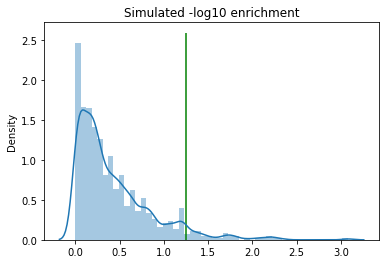

In [22]:
%matplotlib inline
f, ax = plt.subplots()
sns.distplot(all_enrich_l, ax=ax)
perc_thresh = 95
perc_val = np.percentile(all_enrich_l, perc_thresh)
ax.vlines(x=perc_val, ymin=0, ymax=ax.get_ylim()[1],color='g')
plt.title("Simulated -log10 enrichment")

## a2. Plot the sim-max clone distribution

/home/isshamie/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Sim-max -log10 enrichment')

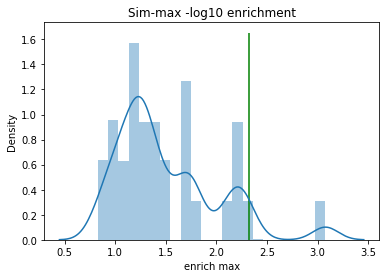

In [23]:
%matplotlib inline
f, ax = plt.subplots()
sns.distplot(all_enrich_max, ax=ax)
perc_thresh = 95
perc_val = np.percentile(all_enrich_max, perc_thresh)
ax.vlines(x=perc_val, ymin=0, ymax=ax.get_ylim()[1], color='g')
plt.title("Sim-max -log10 enrichment")

## b. Plot sim vs real , and include the 95% cutoff

/home/isshamie/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/isshamie/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Simulated enrichment p-value all simulated clones')

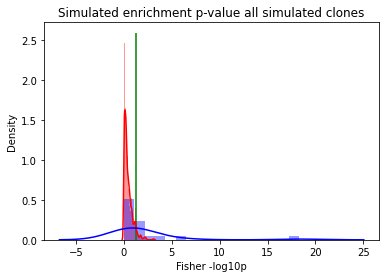

In [26]:
%matplotlib inline
f, ax = plt.subplots()
sns.distplot(np.array(all_enrich_l).flatten(), ax=ax, color='r')
perc_thresh = 95
perc_val = np.percentile(all_enrich_l, perc_thresh)
ax.vlines(x=perc_val, ymin=0, ymax=ax.get_ylim()[1], color='g')

sns.distplot((enrich_df['Fisher -log10p']), ax=ax, color='b')
#plt.xlim([0,1])
plt.title("Simulated enrichment p-value all simulated clones")

## c. Plot sim-max values, vs real , and include the 95% cutoff

/home/isshamie/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/isshamie/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Simulated (red) vs Real (blue) enrichment p-value all max clones\n Green is 95% cutoff ')

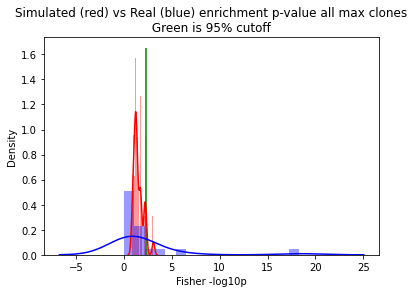

In [27]:
%matplotlib inline
f, ax = plt.subplots()
sns.distplot(np.array(all_enrich_max), ax=ax, color='r')
perc_thresh = 95
perc_val = np.percentile(all_enrich_max, perc_thresh)
ax.vlines(x=perc_val, ymin=0, ymax=ax.get_ylim()[1], color='g')

sns.distplot((enrich_df['Fisher -log10p']), ax=ax, color='b')
#plt.xlim([0,1])
plt.title(f"Simulated (red) vs Real (blue) enrichment p-value all max clones\n Green is {perc_thresh}% cutoff ")

## d. Plot sim cutoff vs clones values as vlines

Text(0.5, 1.0, 'Clones p-value vs Simulated p-value cutoff')

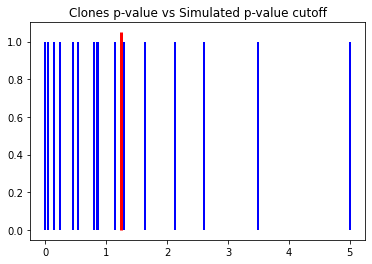

In [33]:
%matplotlib inline
f, ax = plt.subplots()
perc_thresh = 95
perc_val = np.percentile(all_enrich_l, perc_thresh)

for c, c_df in enrich_df.iterrows():
    ax.vlines(x=np.clip(enrich_df['Fisher -log10p'], 0, 5), ymin=0, ymax=1
              , color='b')
    #plt.xlim([0,1])
    
ax.vlines(x=perc_val, ymin=0, ymax=ax.get_ylim()[1], color='r',
         linewidth=3)


plt.title("Clones p-value vs Simulated p-value cutoff")

## e. Plot sim-max cutoff vs clones values as vlines

Text(0.5, 1.0, 'Clones p-value vs Simulated p-value cutoff')

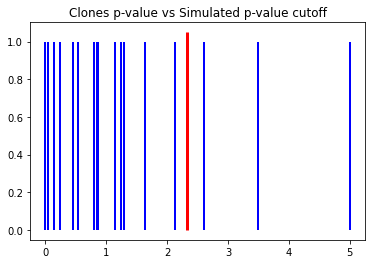

In [34]:
%matplotlib inline
f, ax = plt.subplots()
perc_thresh = 95
perc_val = np.percentile(all_enrich_max, perc_thresh)

for c, c_df in enrich_df.iterrows():
    ax.vlines(x=np.clip((enrich_df['Fisher -log10p']), 0, 5), ymin=0, ymax=1
              , color='b')
    #plt.xlim([0,1])
ax.vlines(x=perc_val, ymin=0, ymax=ax.get_ylim()[1], color='r',
         linewidth=3)



plt.title("Clones p-value vs Simulated p-value cutoff")

## Save p-value cutoff and significant clones using sim-max 95% 

In [35]:
perc_thresh = 95
sig_val = np.percentile(all_enrich_max, perc_thresh)
shuffle_p = enrich_df['Fisher -log10p'].apply(lambda x: sum(x>all_enrich_max)/len(all_enrich_max))

enrich_df['shuffle_sig'] = enrich_df['Fisher -log10p'] > sig_val
enrich_df['shuffle_p'] = shuffle_p

In [36]:
enrich_df

,lineage,# Control Cells in Cluster,# Flt3l Cells in Cluster,Flt3l fold enrichment norm,hypergeom p,Fisher p,Fisher -log10p,-log10p,shuffle_sig,shuffle_p
0,0,8,10,0.972015,4.330523e-01,1.000000e+00,-0.000000,0.363460,False,0.000
1,1,5,20,3.110448,3.092180e-03,2.304088e-02,1.637501,2.509735,False,0.645
2,2,21,44,1.629282,1.951276e-02,7.112245e-02,1.147993,1.709681,False,0.227
3,3,186,91,0.380445,1.000000e+00,4.844802e-19,18.314724,-0.000000,True,1.000
4,4,7,26,2.888273,1.663189e-03,7.564631e-03,2.121212,2.779058,False,0.839
5,5,15,35,1.814428,1.457500e-02,5.743150e-02,1.240850,1.836392,False,0.388
6,6,8,4,0.388806,9.055037e-01,1.441218e-01,0.841270,0.043110,False,0.001
7,7,25,63,1.959582,7.196889e-04,2.498843e-03,2.602261,3.142855,True,0.968
8,8,14,9,0.499893,9.272482e-01,1.357096e-01,0.867389,0.032804,False,0.065
9,9,14,21,1.166418,2.672706e-01,7.308809e-01,0.136153,0.573049,False,0.000


In [ ]:
enrich_df.to_csv(join(OUTDIR, "enrich_stats.csv"))